```
# Copyright 2023 by the author(s) of CHI2023 Late Breaking Work
# "Exploring Physiological Correlates of Visual Complexity Adaptation:
# Insights from EDA, ECG, and EEG Data for Adaptation Evaluation in VR
# Adaptive Systems". All rights reserved.
#
# Use of this source code is governed by a GPLv3 license that
# can be found in the LICENSE file.
```

In [1]:
import tqdm
import pandas as pd
import numpy as np
import neurokit2 as nk
import mne
from mne_icalabel import label_components
mne.set_log_level('WARNING')
from scipy.integrate import simpson # composite Simpson's rule

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'
import seaborn as sns
sns.set_theme(style='ticks')

import warnings
warnings.filterwarnings('ignore')

from lbw import get_event_intervals

/home/changkun/miniconda3/envs/chi23lbw/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
chan_names = ['Fz', 'P3', 'Pz', 'P4', 'PO7', 'Oz', 'PO8']
chan_maps = {
    'Value0': 'Fz',
    'Value1': 'P3',
    'Value2': 'Pz',
    'Value3': 'P4',
    'Value4': 'PO7',
    'Value5': 'Oz',
    'Value6': 'PO8',
}
picks_alpha = ['P3', 'Pz', 'P4']
picks_theta = ['Fz', 'Pz']
picks_beta = ['Fz', 'Pz']

In [3]:
def load_eeg(pid):
    dfEEG = pd.read_csv(f"./data/ID{pid}-EEG.csv")
    dfState = pd.read_csv(f"./data/ID{pid}-state.csv")
    dfAdaptation = pd.read_csv(f"./data/ID{pid}-adaptation.csv")
    dfEEG.rename(columns=chan_maps, inplace=True)
    dfEEG.drop("TimeLsl", axis =1, inplace=True)
    dfEEG['BlockNumber'] = -1
    intervals, workloads = get_event_intervals(dfAdaptation)

    for idx, interval in enumerate(intervals):
        dfEEG.loc[(dfEEG['Time'] >= interval[0]) & (dfEEG['Time'] <= interval[1]), 'workload'] = workloads[idx]
        dfEEG.loc[(dfEEG['Time'] >= interval[0]) & (dfEEG['Time'] <= interval[1]), 'interval_id'] = idx
    dfEEG = dfEEG[dfEEG['workload'].notna()]

    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][2]) & (dfEEG.Time < dfState['Time'][2+1])].index, 'BlockNumber']   = dfState['BlockNumber'][2]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][4]) & (dfEEG.Time < dfState['Time'][4+1])].index, 'BlockNumber']   = dfState['BlockNumber'][4]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][6]) & (dfEEG.Time < dfState['Time'][6+1])].index, 'BlockNumber']   = dfState['BlockNumber'][6]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][8]) & (dfEEG.Time < dfState['Time'][8+1])].index, 'BlockNumber']  = dfState['BlockNumber'][8]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][10]) & (dfEEG.Time < dfState['Time'][10+1])].index, 'BlockNumber'] = dfState['BlockNumber'][10]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][12]) & (dfEEG.Time < dfState['Time'][12+1])].index, 'BlockNumber'] = dfState['BlockNumber'][12]

    dfAll = dfEEG.copy()
    dfAll = dfAll.drop(dfAll[dfAll.BlockNumber < 0].index)
    dfAll = dfAll.dropna()
    dfAll = dfAll.sort_values(by="Time")
    return dfAll

In [4]:
def compute_eeg_feature(group, freqs_range):
    picks = mne.pick_types(group.info, meg=False, eeg=True, eog=False, stim=False)
    psds, freqs = mne.time_frequency.psd_welch(group, proj=False, picks=picks, n_jobs=2, n_per_seg=50, n_overlap=5, n_fft=300)
    idx = np.logical_and(freqs >= freqs_range[0], freqs <= freqs_range[1])
    psds_mean = psds.mean(0)
    freq_res = freqs[1] - freqs[0]
    return simpson(np.log(psds_mean[idx]), dx=freq_res)

def eeg_analysis(df_block, pid):
    info = mne.create_info(ch_names=chan_names, sfreq=250, ch_types='eeg')
    info.set_montage('standard_1020')
    raw = mne.io.RawArray(df_block[chan_names].values.T, info)
    raw_filter = raw.filter(l_freq=1, h_freq=70, fir_design='firwin2')
    raw_filter_notch = raw_filter.notch_filter([50, 100], picks=chan_names, fir_design='firwin')
    raw_filter_notch_ref = raw_filter_notch.set_eeg_reference('average', projection=True)

    ica = mne.preprocessing.ICA(n_components=len(chan_names), random_state=42, max_iter='auto')
    ica.fit(raw_filter_notch_ref)

    ic_labels = label_components(raw_filter_notch_ref, ica, method="iclabel")

    labels = ic_labels["labels"]
    exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]

    reconst_raw = raw_filter_notch_ref.copy()
    ica.apply(reconst_raw, exclude=exclude_idx)
    raw_filter_notch_ref_ica = reconst_raw.copy()

    alpha = compute_eeg_feature(raw_filter_notch_ref_ica.copy().pick_channels(picks_alpha), (8, 12))
    theta = compute_eeg_feature(raw_filter_notch_ref_ica.copy().pick_channels(picks_theta), (4, 8))
    beta  = compute_eeg_feature(raw_filter_notch_ref_ica.copy().pick_channels(picks_beta), (12, 25))
    return pid, len(exclude_idx), alpha, theta, beta, raw_filter_notch_ref_ica

In [5]:
pid_valid = [1, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]
df_all = {}

for pid in tqdm.tqdm(pid_valid):
    df = load_eeg(pid)
    df_all[pid] = df

df = pd.DataFrame(columns=['pid', 'workload', 'n_ica', 'alpha', 'theta', 'beta'])
for pid in tqdm.tqdm(pid_valid):
    df_current = df_all[pid]
    for interval_id in df_current.interval_id.unique():
        df_event = df_all[pid][df_all[pid].interval_id == interval_id]
        if len(df_event) < 1000: # the data is too short to compute ica
            continue

        pid, n_ica, alpha, theta, beta, _ = eeg_analysis(df_event, pid)
        workload = df_event['workload'].values[0]
        df = df.append({
            'pid': pid,
            'n_ica': n_ica,
            'interval': interval_id,
            'workload': workload,
            'alpha': alpha,
            'theta': theta,
            'beta': beta,
        }, ignore_index=True)
df

100%|██████████| 11/11 [00:58<00:00,  5.32s/it]


,pid,workload,n_ica,alpha,theta,beta,interval
0,1,low,0,1.285121,3.164314,-1.439646,0.0
1,1,high,0,2.075275,3.703505,5.764936,1.0
2,1,low,0,8.538782,4.835964,5.480579,2.0
3,1,high,0,1.940613,2.877174,7.191034,3.0
4,1,low,0,1.904074,4.529959,1.915914,4.0
...,...,...,...,...,...,...,...
102,13,low,0,22.008694,18.039341,39.501176,14.0
103,14,low,0,10.914421,17.394413,36.898880,0.0
104,14,high,0,7.804129,13.631666,28.184074,1.0
105,14,low,0,9.129773,10.921125,20.889585,2.0


In [6]:
df['alpha_theta_ratio'] = df['alpha'] / df['theta']
df['beta_theta_ratio'] = df['beta'] / df['theta']
df.to_csv('processed/eeg.csv')

df['alpha_log'] = np.log(df['alpha'])
df['theta_log'] = np.log(df['theta'])
df['beta_log'] = np.log(df['beta'])

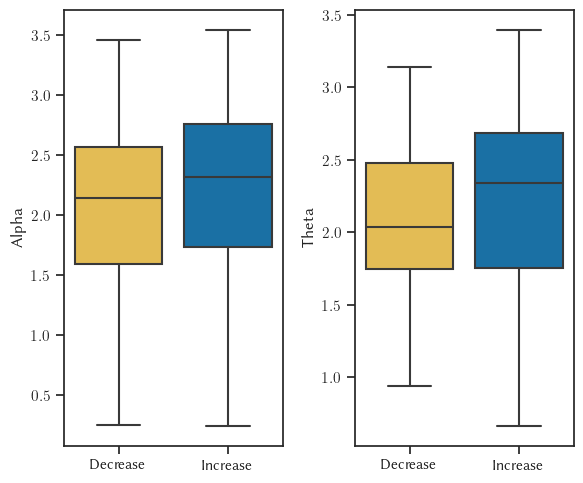

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))
colors = list({'yellow' : '#FBC63D', 'blue': '#0376BB'}.values())
sns.boxplot(x='workload', y='alpha_log', data=df, ax=axes[0], palette=colors, showfliers=False)
sns.boxplot(x='workload', y='theta_log', data=df, ax=axes[1], palette=colors, showfliers=False)

axes[0].set_ylabel('Alpha')
axes[1].set_ylabel('Theta')

axes[0].set_xticklabels(['Decrease', 'Increase'])
axes[1].set_xticklabels(['Decrease', 'Increase'])

axes[0].set_xlabel('')
axes[1].set_xlabel('')

plt.tight_layout()
plt.savefig('figures/fig3a.pdf')

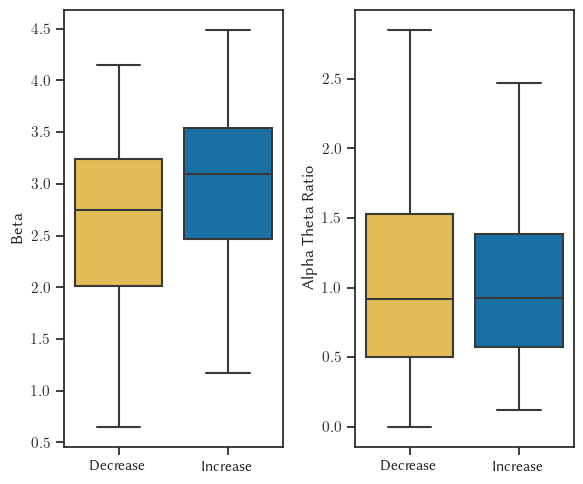

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))
colors = list({'yellow' : '#FBC63D', 'blue': '#0376BB'}.values())
sns.boxplot(x='workload', y='beta_log', data=df, ax=axes[0], palette=colors, showfliers=False)
sns.boxplot(x='workload', y='alpha_theta_ratio', data=df, ax=axes[1], palette=colors, showfliers=False)

axes[0].set_ylabel('Beta')
axes[1].set_ylabel('Alpha Theta Ratio')

axes[0].set_xticklabels(['Decrease', 'Increase'])
axes[1].set_xticklabels(['Decrease', 'Increase'])

axes[0].set_xlabel('')
axes[1].set_xlabel('')

plt.tight_layout()
plt.savefig('figures/fig3b.pdf')

In [9]:
df = pd.DataFrame(columns=['pid', 'workload', 'n_ica', 'alpha', 'theta', 'beta'])

increased_raws = []
decreased_raws = []

for pid in tqdm.tqdm(pid_valid):
    df_current = df_all[pid]
    for interval_id in df_current.interval_id.unique():
        df_event = df_all[pid][df_all[pid].interval_id == interval_id]
        if len(df_event) < 1000: # the data is too short to compute ica
            continue

        pid, n_ica, alpha, theta, beta, raw = eeg_analysis(df_event, pid)
        workload = df_event['workload'].values[0]
        df = df.append({'pid': pid, 'n_ica': n_ica, 'interval_id': interval_id, 'workload': workload, 'alpha': alpha, 'theta': theta, 'beta': beta}, ignore_index=True)

        if workload == 'low':
            decreased_raws.append(raw)
        else:
            increased_raws.append(raw)
df

100%|██████████| 11/11 [00:58<00:00,  5.34s/it]


,pid,workload,n_ica,alpha,theta,beta,interval_id
0,1,low,0,1.285121,3.164314,-1.439646,0.0
1,1,high,0,2.075275,3.703505,5.764936,1.0
2,1,low,0,8.538782,4.835964,5.480579,2.0
3,1,high,0,1.940613,2.877174,7.191034,3.0
4,1,low,0,1.904074,4.529959,1.915914,4.0
...,...,...,...,...,...,...,...
102,13,low,0,22.008694,18.039341,39.501176,14.0
103,14,low,0,10.914421,17.394413,36.898880,0.0
104,14,high,0,7.804129,13.631666,28.184074,1.0
105,14,low,0,9.129773,10.921125,20.889585,2.0


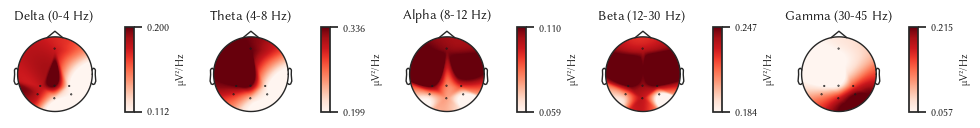

In [13]:
raw_increase = mne.concatenate_raws(increased_raws[2:])
raw_increase.plot_psd_topomap(ch_type='eeg', normalize=True, n_fft=300, n_overlap=5, n_per_seg=50, proj=False, show=False)
plt.savefig('figures/fig2topomap_increase.pdf', dpi=300)

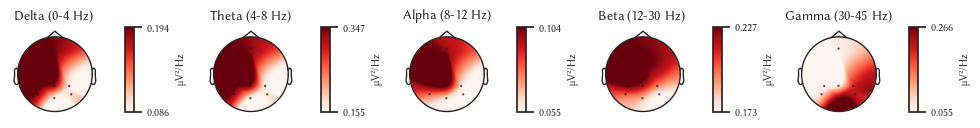

In [14]:
raw_decrease = mne.concatenate_raws(decreased_raws[2:])
raw_decrease.plot_psd_topomap(ch_type='eeg', normalize=True, n_fft=300, n_overlap=5, n_per_seg=50, proj=False, show=False)
plt.savefig('figures/fig2topomap_decrease.pdf', dpi=300)